# Finite differences in infinite domains


<small>
    <i>
    This notebook originally appeared as a post on <a href="https://nicoguaro.github.io">my blog</a>.
    </i>
</small>

Because of my friend, [Edward Villegas](http://cosmoscalibur.com/), I ended up thinking about using a change of variables
when solving an eigenvalue problem with finite difference.

## The problem
Let's say that we want to solve a differential equation over an infinite domain. A common case
is to solve the [Time independent Schrödinger equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation#Time-independent_equation) subject to a potential $V(x)$. For example

$$-\frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}x^2}\psi(x) + V(x) \psi(x) = E\psi(x),\quad \forall x\in (-\infty, \infty),$$

where we want to find the pairs of eigenvalues/eigenfunctions $(E_n, \psi_n(x))$.


What I normally do when using [finite differences](https://en.wikipedia.org/wiki/Finite_difference_method) is to regularly divide the domain. Where I take a _large enough_ domain, so the solution have decayed
close to zero. What I do in this post is to make a change of variable to render the interval finite first
and then regularly divide the transformed domain in finite intervals.


## My usual approach

My usual approach is to approach the second derivative with a
[centered difference](https://en.wikipedia.org/wiki/Finite_difference_coefficient)
for the point $x_i$ like this

$$\frac{\mathrm{d}^2 f(x)}{\mathrm{d}x^2} \approx \frac{f(x + \Delta x) - 2 f(x_i) + f(x - \Delta x)}{\Delta x^2}\, ,$$

with $\Delta x$ the separation between points.

We can solve this in Python with the following snippet:

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import eigs


def regular_FD(pot, npts=101, x_max=10, nvals=6):
    """
    Find eigenvalues/eigenfunctions for Schrodinger
    equation for the given potential `pot` using
    finite differences
    """
    x = np.linspace(-x_max, x_max, npts)
    dx = x[1] - x[0]
    D2 = diags([1, -2, 1], [-1, 0, 1], shape=(npts, npts))/dx**2
    V = diags(pot(x))
    H = -0.5*D2 + V
    vals, vecs = eigs(H, k=nvals, which="SM")
    return x, np.real(vals), vecs

In [2]:
# Jupyter notebook plotting setup & imports
%matplotlib notebook
import matplotlib.pyplot as plt

gray = '#757575'
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["text.color"] = gray
fontsize = plt.rcParams["font.size"] = 12
plt.rcParams["xtick.color"] = gray
plt.rcParams["ytick.color"] = gray
plt.rcParams["axes.labelcolor"] = gray
plt.rcParams["axes.edgecolor"] = gray
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Let's consider the [Quantum harmonic oscillator](https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator),
that has as eigenvalues

$$E_n = n + \frac{1}{2},\quad \forall n = 0, 1, 2 \cdots$$

Using the finite difference method we have values that are really close to the analytic ones.

In [3]:
x, vals, vecs = regular_FD(lambda x: 0.5*x**2, npts=201)
vals

array([0.4996873 , 1.49843574, 2.49593063, 3.49216962, 4.48715031,
       5.4808703 ])

In [4]:
anal_vals = np.array(range(6)) + 0.5
anal_vals

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

<IPython.core.display.Javascript object>


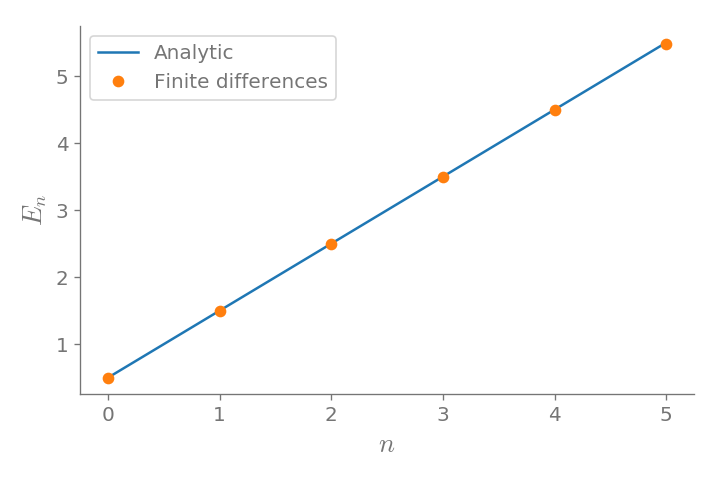

In [5]:
plt.figure()
plt.plot(anal_vals)
plt.plot(vals, "o")
plt.xlabel(r"$n$", fontsize=16)
plt.ylabel(r"$E_n$", fontsize=16)
plt.legend(["Analytic", "Finite differences"])
plt.tight_layout();

Let's see the eigenfunctions.

<IPython.core.display.Javascript object>


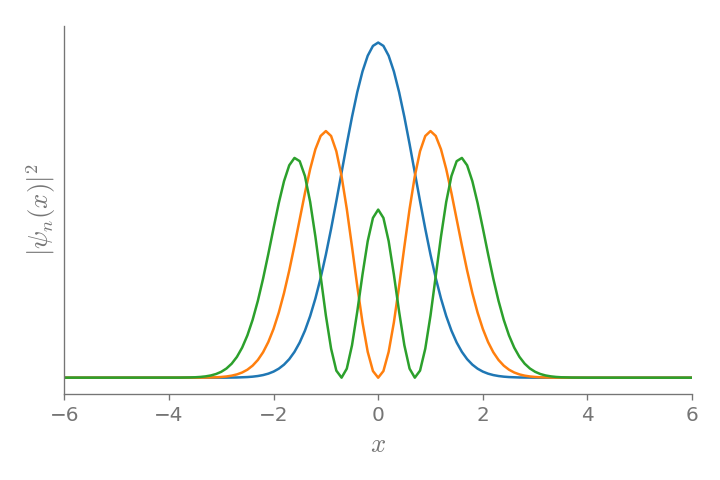

In [6]:
plt.figure()
plt.plot(x, np.abs(vecs[:, :3])**2)
plt.xlim(-6, 6)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$|\psi_n(x)|^2$", fontsize=16)
plt.yticks([])
plt.tight_layout();

One inconvenient with this method is the redundant sampling towards the extreme of the intervals, while under sample the middle part.

## Changing the domain

Let's now consider the case where we transform the infinite domain to a finite one with 
a change of variable

$$\xi = \xi(x)$$

with $\xi \in (-1, 1)$. Two options for this transformation are:

- $\xi = \tanh x$; and
- $\xi = \frac{2}{\pi} \arctan x$.

Making this change of variable the equation we need to solve the following equation

$$-\frac{1}{2}\left(\frac{\mathrm{d}\xi}{\mathrm{d}x}\right)^2\frac{\mathrm{d}^2}{\mathrm{d}\xi^2}\psi(\xi) - \frac{\mathrm{d}^2\xi}{\mathrm{d}x^2}\frac{\mathrm{d}}{\mathrm{d}\xi}\psi(\xi) + V(x) \psi(x) = E\psi(x)$$

The following snippet solve the eigenproblem for the mapped domain:

In [7]:
def mapped_FD(pot, fun, dxdxi, dxdxi2, npts=101, nvals=6, xi_tol=1e-6):
    """
    Find eigenvalues/eigenfunctions for Schrodinger
    equation for the given potential `pot` using
    finite differences over a mapped domain on (-1, 1)
    """
    xi = np.linspace(-1 + xi_tol, 1 - xi_tol, npts)
    x = fun(xi)
    dxi = xi[1] - xi[0]
    D2 = diags([1, -2, 1], [-1, 0, 1], shape=(npts, npts))/dxi**2
    D1 = 0.5*diags([-1, 1], [-1, 1], shape=(npts, npts))/dxi
    V = diags(pot(x))
    fac1 = diags(dxdxi(xi)**2)
    fac2 = diags(dxdxi2(xi))
    H = -0.5*fac1.dot(D2) - 0.5*fac2.dot(D1) + V
    vals, vecs = eigs(H, k=nvals, which="SM")
    return x, np.real(vals), vecs

### First transformation: $\xi = \tanh(x)$


Let's consider first the transformation

$$\xi = \tanh(x)\, .$$

In this case


$$\frac{\mathrm{d}\xi}{\mathrm{d}x} = 1 - \tanh^2(x) = 1 - \xi^2\, ,$$

and

$$\frac{\mathrm{d}^2\xi}{\mathrm{d}x^2} = -2\tanh(x)[1 - \tanh^2(x)] = -2\xi[1 - \xi^2]\, .$$



In [8]:
pot = lambda x: 0.5*x**2
fun = lambda xi: np.arctanh(xi)
dxdxi = lambda xi: 1 - xi**2
dxdxi2 = lambda xi: -2*xi*(1 - xi**2)


In [9]:
x, vals, vecs = mapped_FD(pot, fun, dxdxi, dxdxi2, npts=201)
vals

array([0.49989989, 1.4984226 , 2.49003572, 3.46934257, 4.46935021,
       5.59552989])

<IPython.core.display.Javascript object>


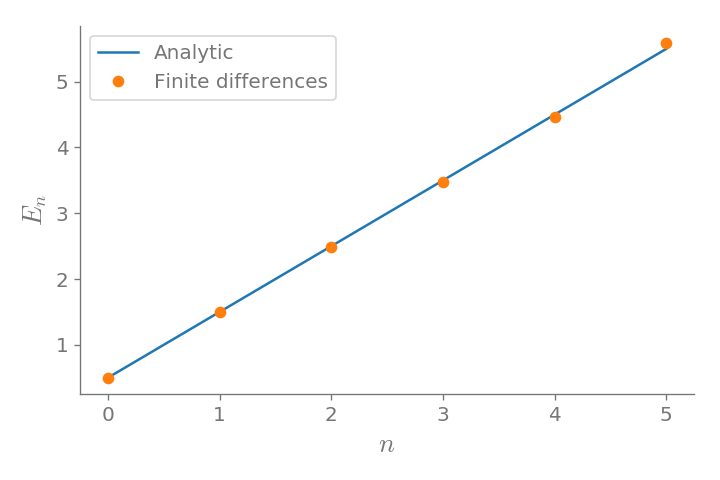

In [10]:
plt.figure()
plt.plot(anal_vals)
plt.plot(vals, "o")
plt.legend(["Analytic", "Finite differences"])
plt.xlabel(r"$n$", fontsize=16)
plt.ylabel(r"$E_n$", fontsize=16)
plt.tight_layout();

<IPython.core.display.Javascript object>


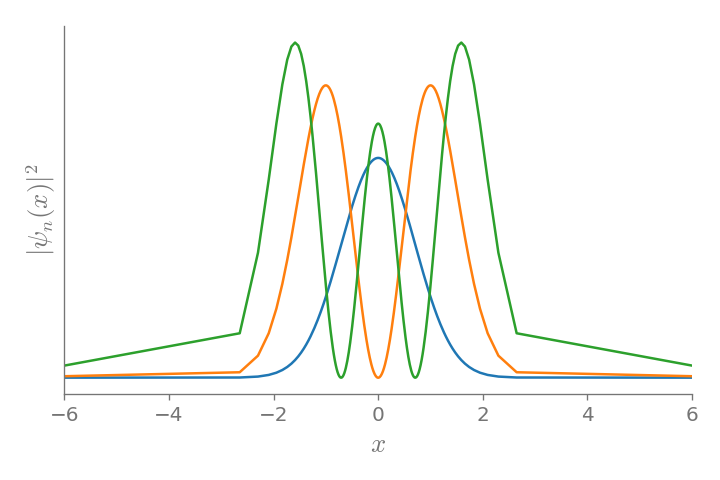

In [11]:
plt.figure()
plt.plot(x, np.abs(vecs[:, :3])**2)
plt.xlim(-6, 6)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$|\psi_n(x)|^2$", fontsize=16)
plt.yticks([])
plt.tight_layout();

### Second transformation: $\xi = \frac{2}{\pi}\mathrm{atan}(x)$


Let's consider first the transformation

$$\xi = \frac{2}{\pi}\mathrm{atan}(x)\, .$$

In this case


$$\frac{\mathrm{d}\xi}{\mathrm{d}x} = \frac{2}{\pi(1 + x^2)} = \frac{2 \cos^2\xi}{\pi} \, ,$$

and

$$\frac{\mathrm{d}^2\xi}{\mathrm{d}x^2} = -\frac{4x}{\pi(1 + x^2)^2} = -\frac{4 \cos^4\xi \tan \xi}{\pi}\, .$$


In [12]:
pot = lambda x: 0.5*x**2
fun = lambda xi: np.tan(0.5*np.pi*xi)
dxdxi = lambda xi: 2/np.pi * np.cos(0.5*np.pi*xi)**2
dxdxi2 = lambda xi: -4/np.pi * np.cos(0.5*np.pi*xi)**4 * np.tan(0.5*np.pi*xi)

In [13]:
x, vals, vecs = mapped_FD(pot, fun, dxdxi, dxdxi2, npts=201)
vals

array([0.49997815, 1.49979632, 2.49930872, 3.49824697, 4.49627555,
       5.49295665])

<IPython.core.display.Javascript object>


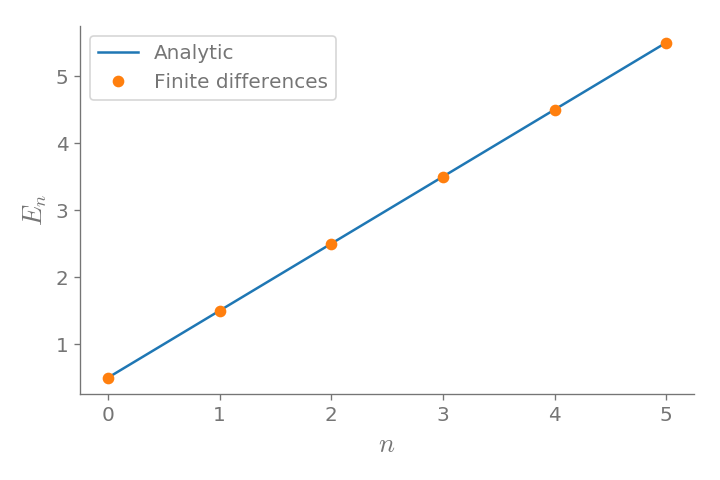

In [14]:
plt.figure()
plt.plot(anal_vals)
plt.plot(vals, "o")
plt.legend(["Analytic", "Finite differences"])
plt.xlabel(r"$n$", fontsize=16)
plt.ylabel(r"$E_n$", fontsize=16)
plt.tight_layout();

<IPython.core.display.Javascript object>


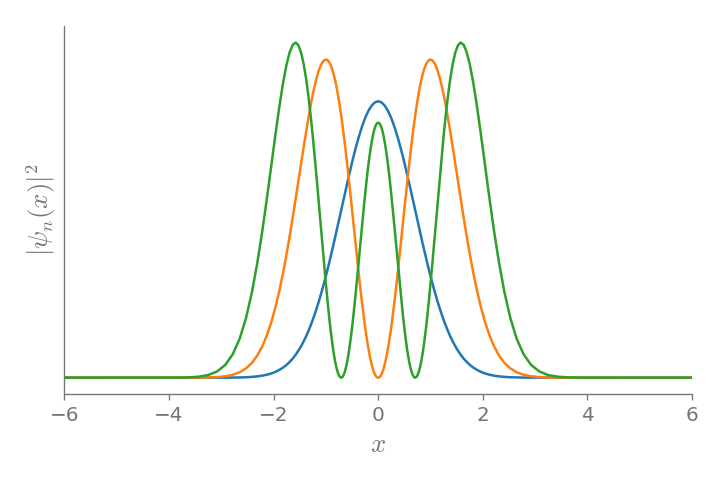

In [15]:
plt.figure()
plt.plot(x, np.abs(vecs[:, :3])**2)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$|\psi|^2$", fontsize=16)
plt.xlim(-6, 6)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$|\psi_n(x)|^2$", fontsize=16)
plt.yticks([])
plt.tight_layout();

## Conclusion

The method works fine, although the differential equation is more convoluted do to the change of variable. Although, there are more elegant methods to consider infinite domains, this is simple enough to be solved in 10 lines of code.

We can see that the mapping $\xi = \mathrm{atan}(x)$, covers better the domain than  $\xi = \tanh(x)$, where most of the points are placed in the center of the interval.


